In [2]:


import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/PC/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools

In [3]:
train_df = pd.read_csv('DelhiClimateTrain.csv', parse_dates=['date'], index_col=['date'])
test_df = pd.read_csv('DelhiClimateTest.csv', parse_dates=['date'], index_col=['date'])

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


In [6]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [7]:
train_df['meanpressure'].max(), train_df['meanpressure'].min(), train_df['meanpressure'].mean()

(7679.333333333333, -3.0416666666666665, 1011.1045475940377)

In [8]:
train_df.loc[train_df['meanpressure'] == train_df['meanpressure'].max()].index

DatetimeIndex(['2016-03-28'], dtype='datetime64[ns]', name='date', freq=None)

Training data and constructing graphs

In [9]:
train_df = train_df[(train_df['meanpressure'] > 950) & (train_df['meanpressure'] < 1090)]

Text(0.5, 0, 'Date')

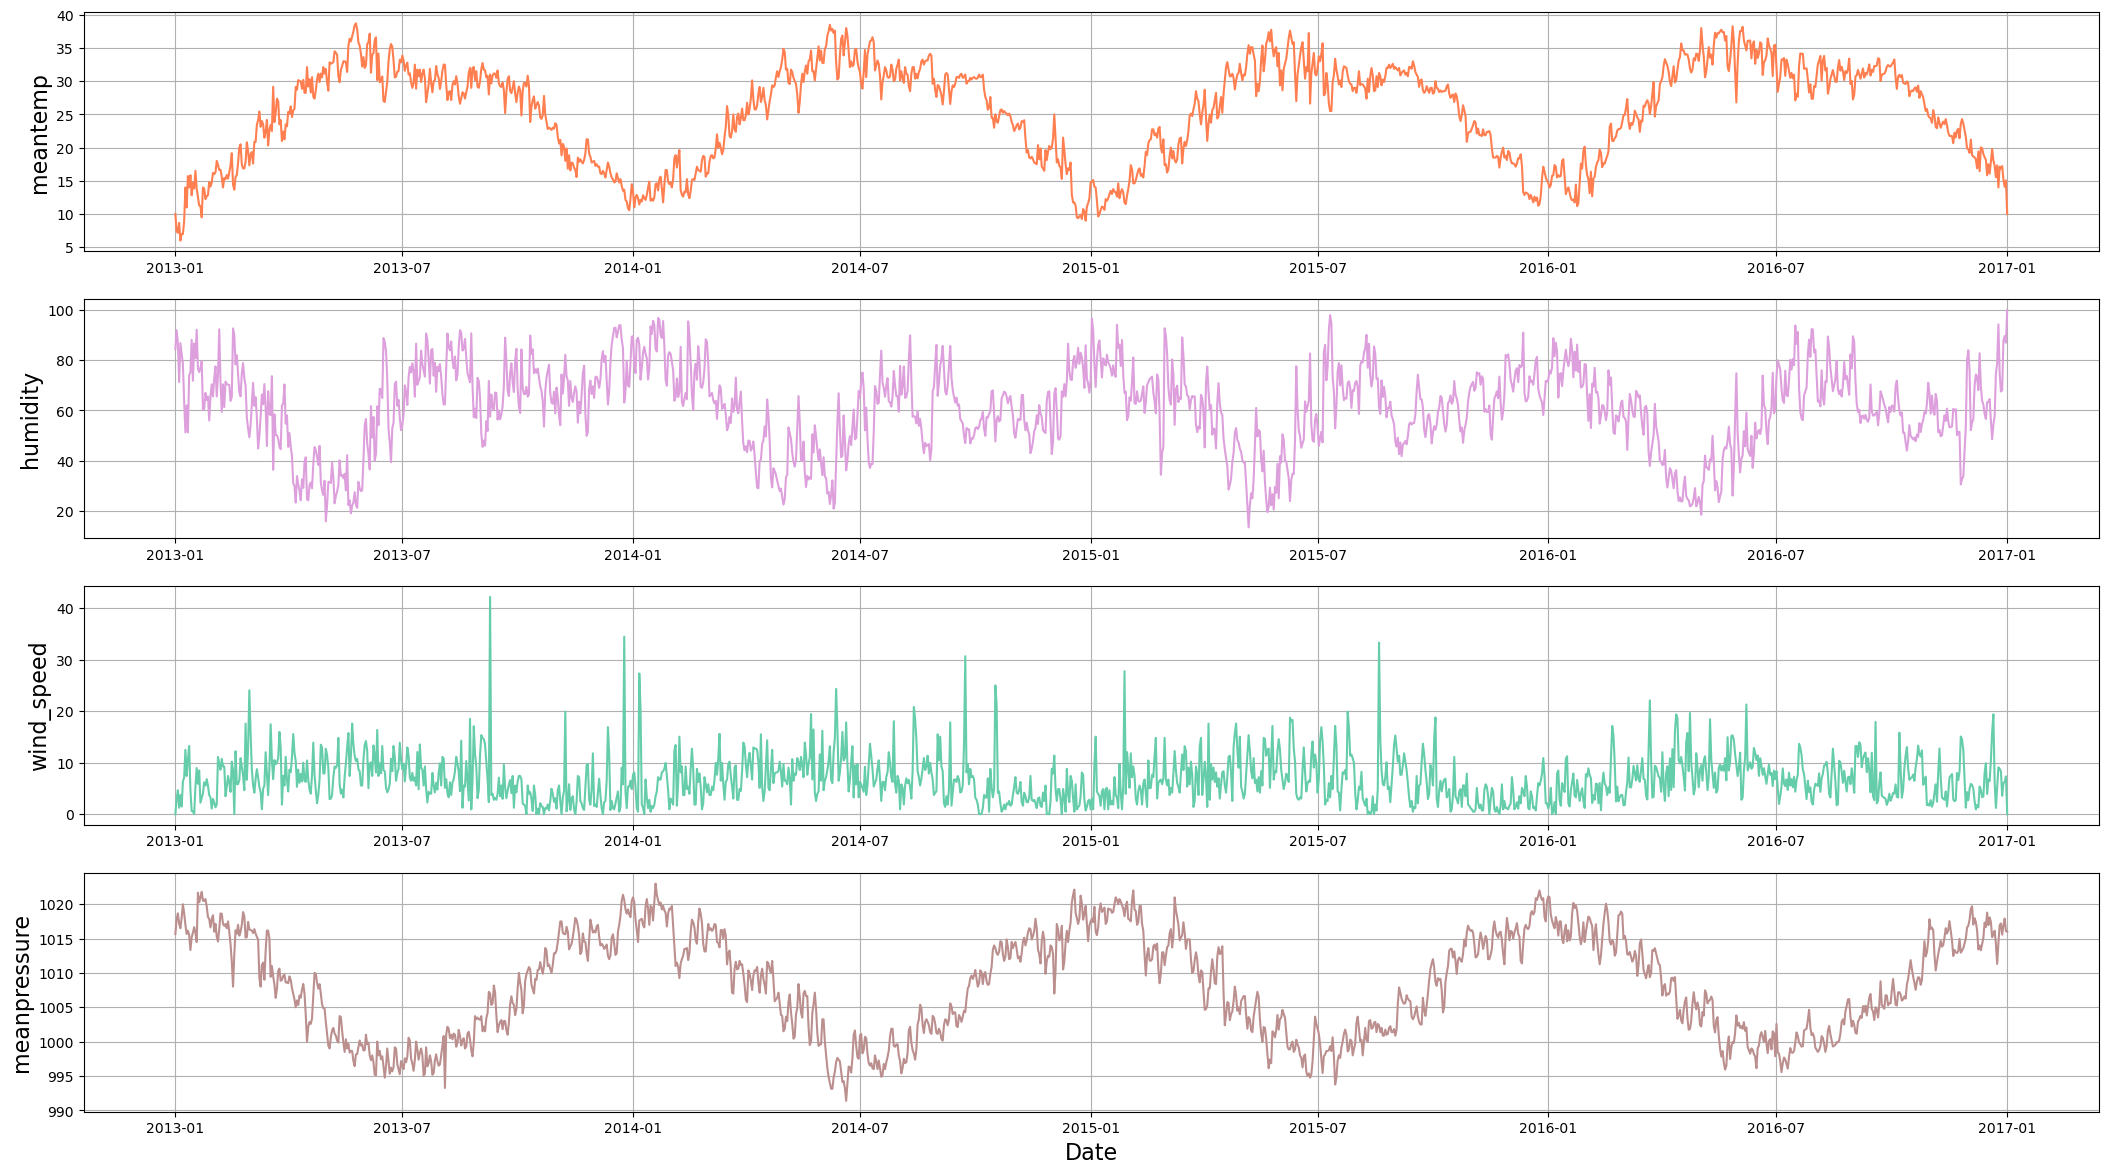

In [10]:
plt.figure(figsize=(26, 18))
colors = ['#FF7F50', '#DDA0DD', '#66CDAA', '#BC8F8F']
for i, j in enumerate(train_df.columns):
  plt.subplot(len(train_df.columns) + 1, 1, i + 1)
  plt.plot(train_df[j], color=colors[i]);
  plt.ylabel(j, fontsize=16)
  plt.grid()
plt.xlabel('Date', fontsize=16)

In [11]:
train_df_2015 = train_df['2015-01-01': '2016-01-01']

Text(0.5, 0, 'Date')

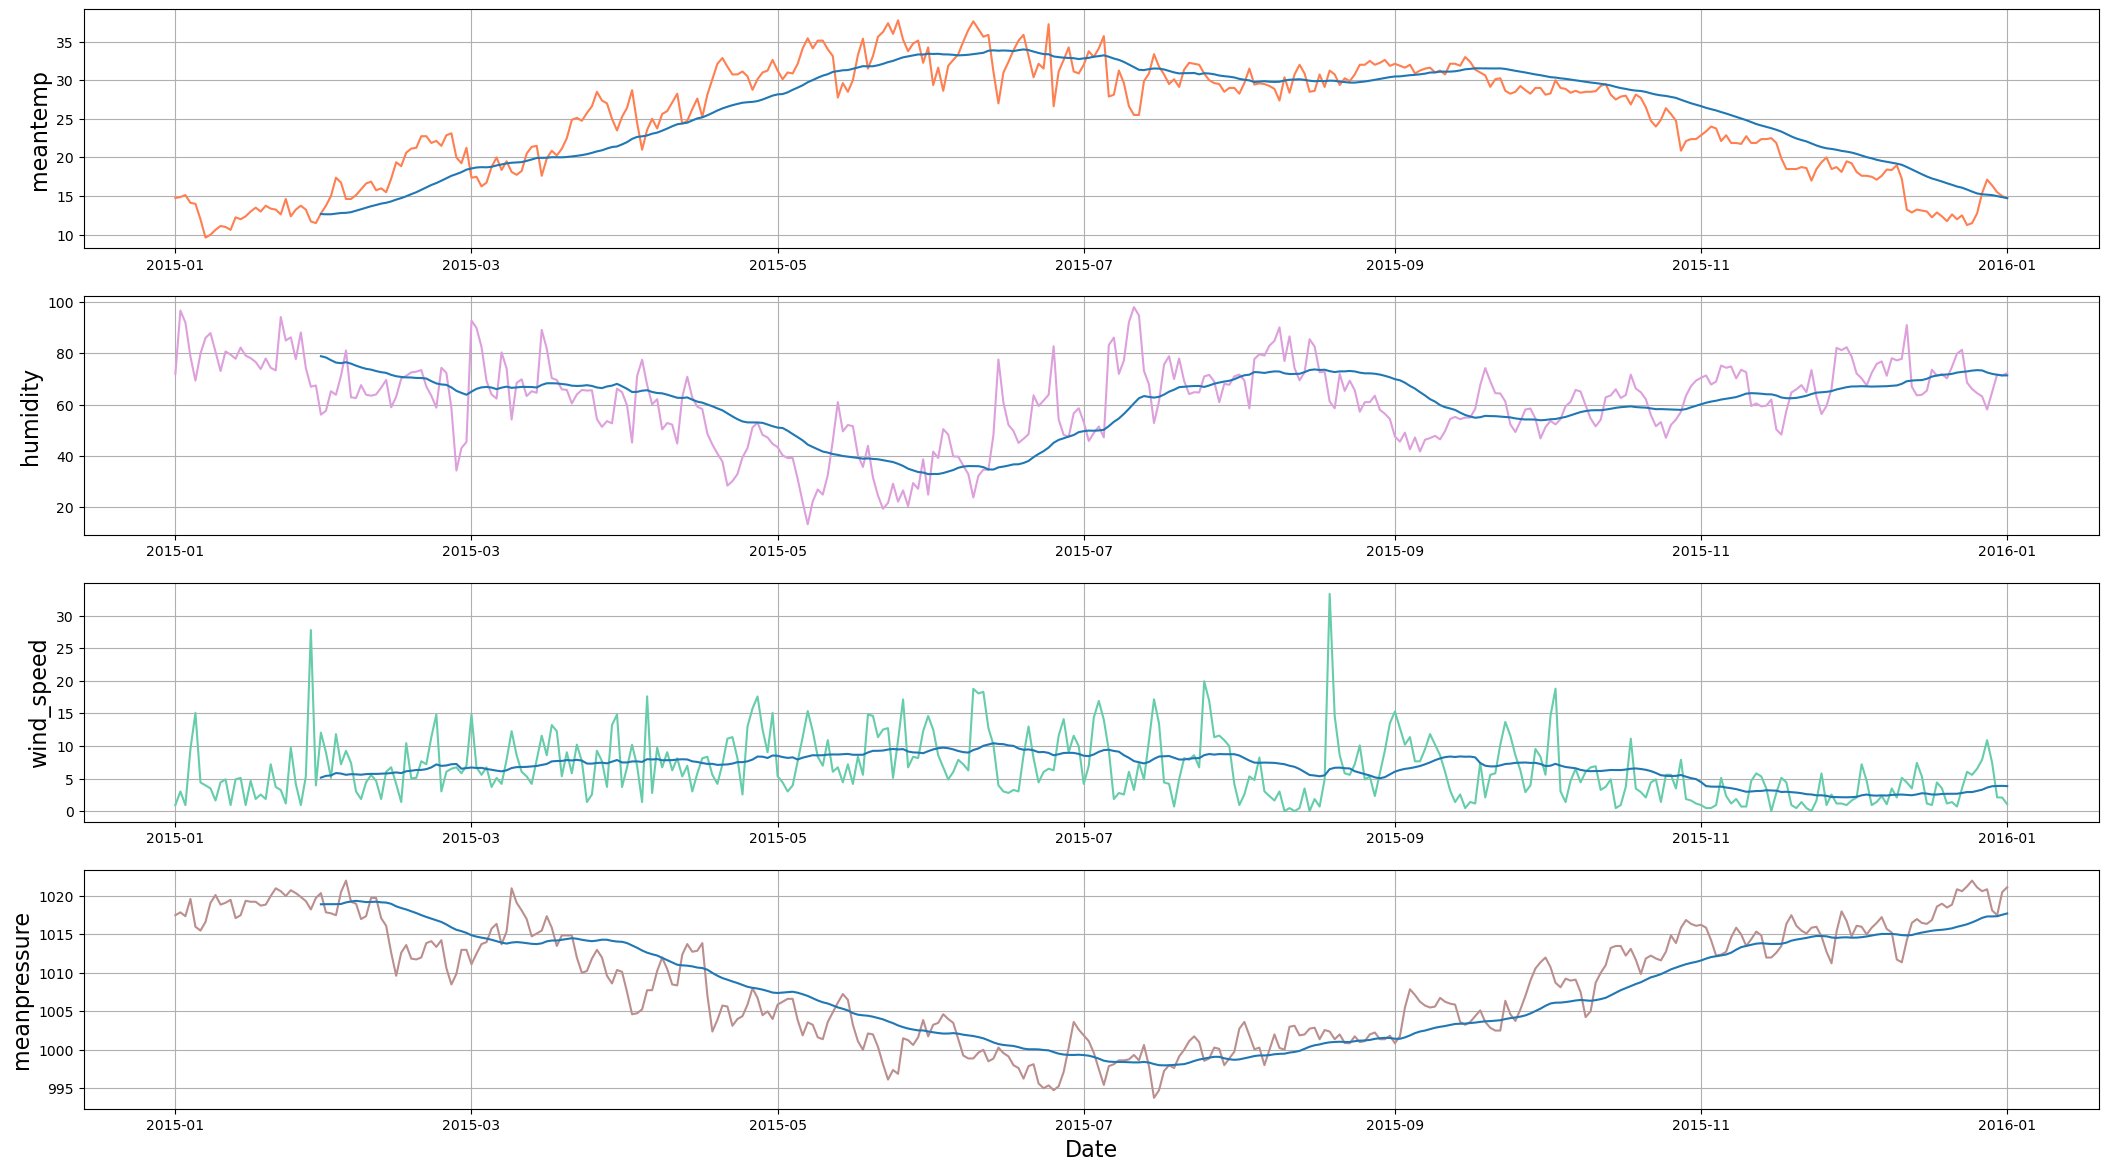

In [12]:
plt.figure(figsize=(26, 18))
colors = ['#FF7F50', '#DDA0DD', '#66CDAA', '#BC8F8F']
for i, j in enumerate(train_df_2015.columns):
  plt.subplot(len(train_df_2015.columns) + 1, 1, i + 1)
  plt.plot(train_df_2015[j], color=colors[i]);
  plt.plot(train_df_2015[j].rolling(30).mean());
  plt.ylabel(j, fontsize=16)
  plt.grid()
plt.xlabel('Date', fontsize=16)

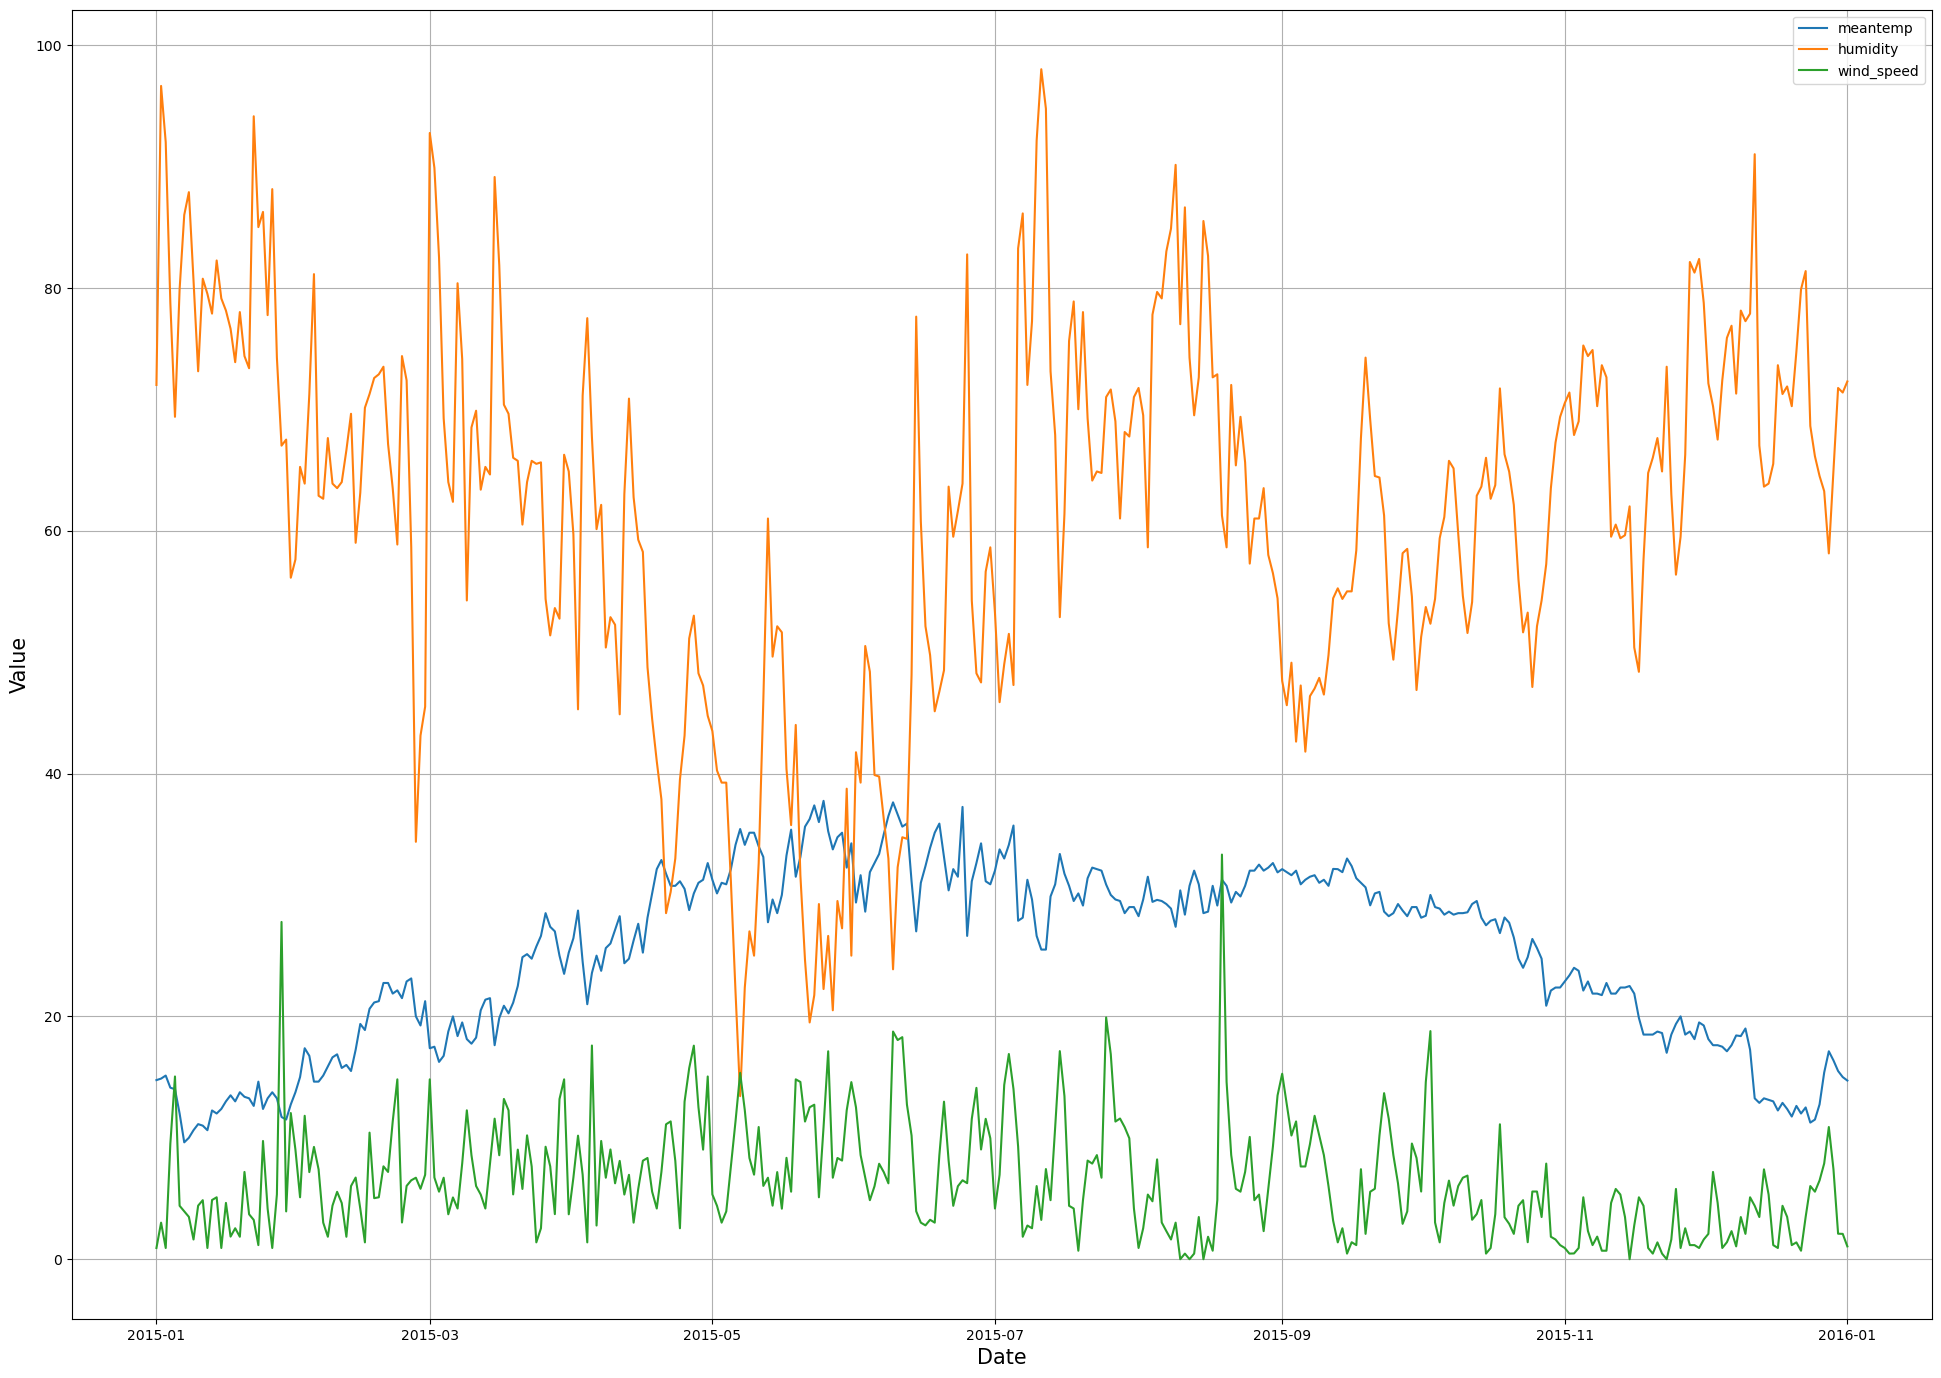

In [13]:
plt.figure(figsize=(24, 17))
for i in train_df_2015.columns[:-1]:
  plt.plot(train_df_2015[i], label=i)
  plt.xlabel("Date", fontsize = 15)
  plt.ylabel('Value', fontsize = 15)
  plt.legend()
  plt.grid(True)

In [14]:
ts_decomposition = seasonal_decompose(x=train_df['meantemp'], model='additive', period=365)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

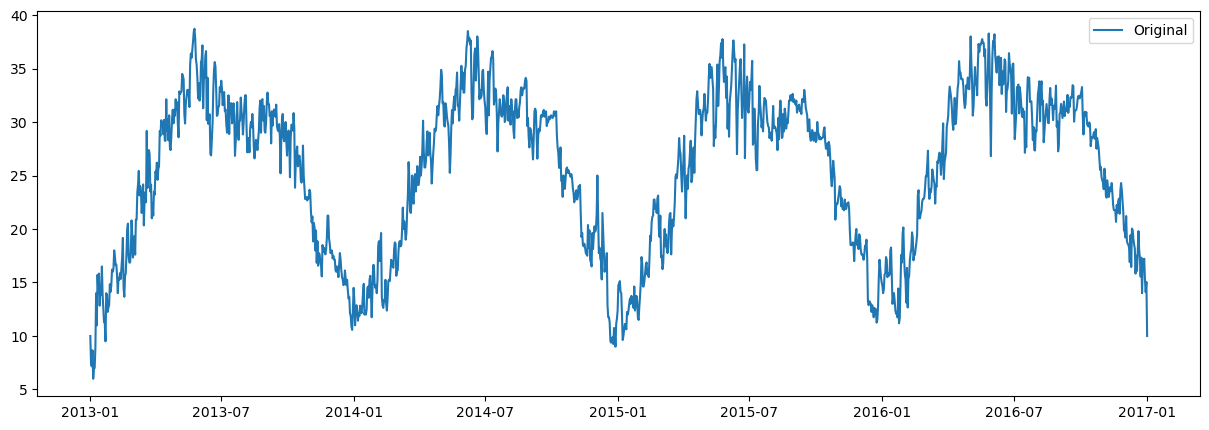

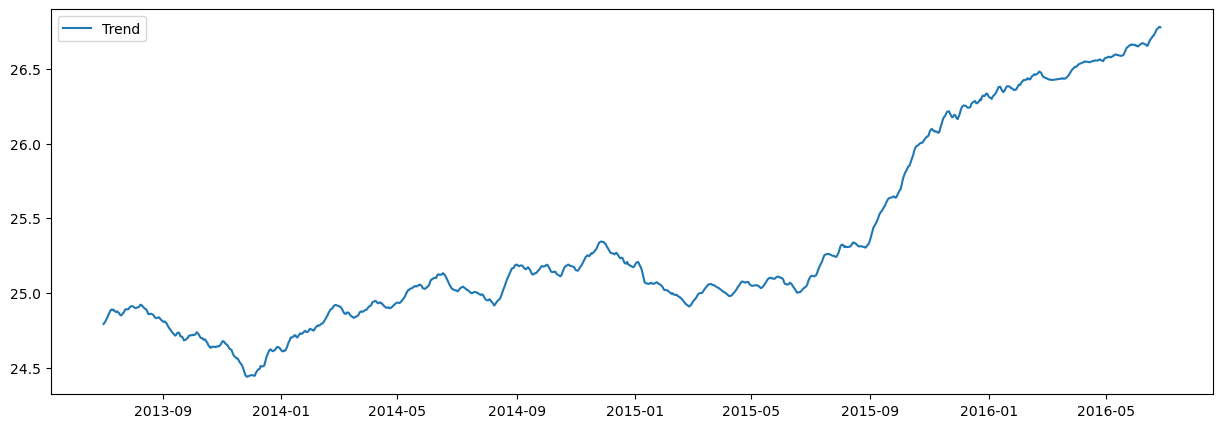

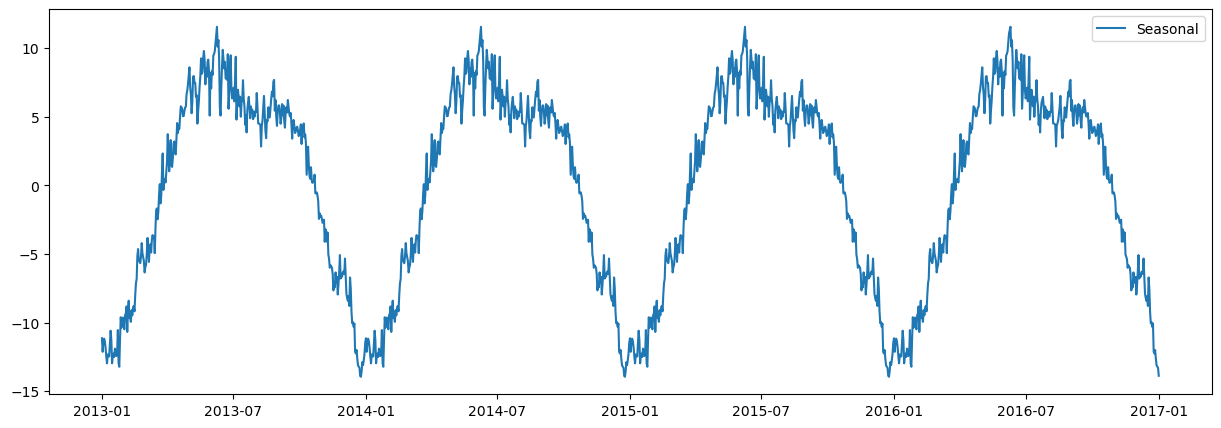

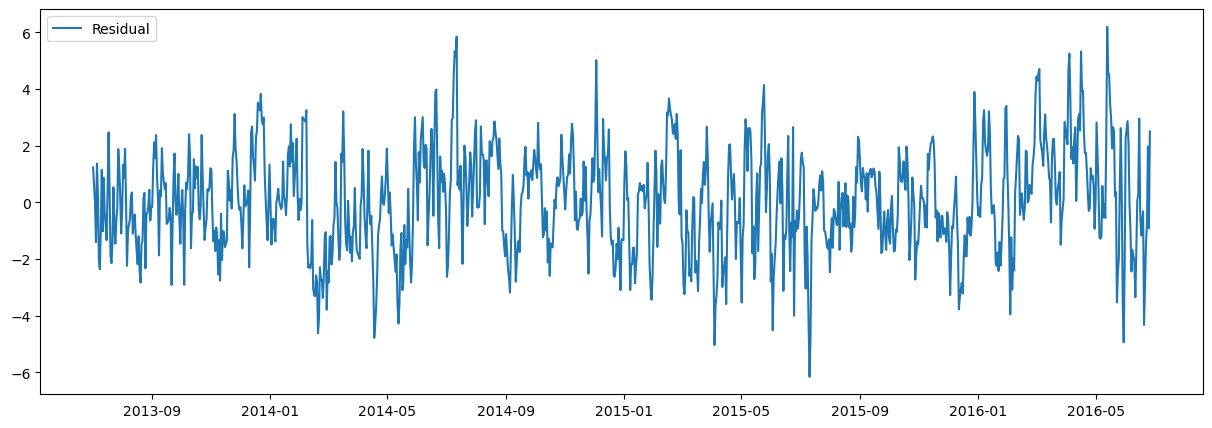

In [15]:
plt.figure(figsize=(15,5))
plt.plot(train_df['meantemp'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [16]:
n_cols = 1
dataset = train_df["meantemp"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(1453, 1)

In [17]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1089 Test Size : 364


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [19]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1089, 1)

In [20]:

x_train = []
y_train = []
time_steps = 60
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[0.12227074],
       [0.04279476],
       [0.0356623 ],
       [0.08151383],
       [0.        ],
       [0.03056769],
       [0.03056769],
       [0.08733624],
       [0.24454148],
       [0.15283843],
       [0.29694323],
       [0.24454148],
       [0.30058224],
       [0.20887918],
       [0.26637555],
       [0.23944687],
       [0.3209607 ],
       [0.23944687],
       [0.19868996],
       [0.16157205],
       [0.15895197],
       [0.1069869 ],
       [0.24454148],
       [0.23944687],
       [0.19104803],
       [0.20378457],
       [0.20960699],
       [0.27001456],
       [0.24836245],
       [0.26637555],
       [0.31179039],
       [0.30567686],
       [0.31441048],
       [0.36681223],
       [0.34934498],
       [0.32478166],
       [0.32605531],
       [0.29344978],
       [0.24454148],
       [0.28820961],
       [0.28275109],
       [0.3018559 ],
       [0.2852984 ],
       [0.31441048],
       [0.34643377],
       [0.40247453],
       [0.25764192],
  

In [21]:

x_train, y_train = np.array(x_train), np.array(y_train)

In [22]:

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [23]:
x_train.shape , y_train.shape

((1393, 60, 1), (1393, 1))